# EXTENDED FIGURE 8

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import cloudvolume
from caveclient import CAVEclient
import nglui
from statistics import mean
import matplotlib.pyplot as plt

#client = CAVEclient('minnie65_phase3_v1')
#client.info.get_datastack_info()

In [2]:
#Load dataframe
synapse_table = pd.read_feather("ET_column_synapse_table.feather")

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
synapse_table.head()

,ctr_pt_position,synapse_id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,pre_pt_mesh_ind_filt,dist_to_root,distance_rank,pre_nucleus_id,post_nucleus_id,post_soma_pt,NEURD_class,metamodel_class,metamodel_cell_type,mtypes_model_cell_type,mtypes_column,motif_group,post_soma_area,pre_soma_pt,pre_soma_area,manual_class_original,manual_subclass_original,num_soma,inhibitory_groups,manual_subclass,manual_class,consensus_class,consensus_subclass,class_from_subclass,check_class_from_subclass
0,"[154418, 214622, 20098]",119648357,"[154432, 214682, 20097]",864691135848920670,86011221899388242,1.580688e+17,1493,"[154430, 214570, 20104]",864691135781927760,86011221899392293,11732,1493,187341.750702,55.0,267008,266505.0,"[166240, 199152, 18693]",inhibitory,excitatory,5P-IT,5P-IT,None,NaN,v1,"[169216, 196416, 20820]",v1,None,None,1.0,0,MC,inhibitory,inhibitory,MC,inhibitory,OK
1,"[142218, 213642, 19028]",98028751,"[142196, 213598, 19026]",864691135432713458,84322234465917066,1.563798e+17,323,"[142248, 213590, 19024]",864691135781927760,84322234465919154,19272,323,251194.960907,99.0,267008,266412.0,"[173200, 203632, 17692]",excitatory,excitatory,5P-ET,5P-ET,None,NaN,v1,"[169216, 196416, 20820]",v1,None,None,1.0,0,None,None,excitatory,5P-ET,excitatory,OK
2,"[175767, 211411, 20943]",162814928,"[175762, 211352, 20948]",864691136974810140,88966296905416965,1.610239e+17,7472,"[175852, 211392, 20949]",864691135781927760,88966296905424589,7108,7472,252353.357544,100.0,267008,369667.0,"[218176, 204112, 20337]",None,inhibitory,MC,None,None,NaN,v1,"[169216, 196416, 20820]",v1,inhibitory,MC,1.0,0,MC,inhibitory,inhibitory,MC,inhibitory,OK
3,"[160788, 214224, 20539]",134843766,"[160824, 214178, 20534]",864691134886001146,86925946921252564,1.589132e+17,2877,"[160726, 214240, 20539]",864691135781927760,86855646896563989,8100,2877,149581.132599,27.0,267008,339621.0,"[197744, 220592, 20239]",excitatory,excitatory,6P,6P,None,NaN,v1,"[169216, 196416, 20820]",v1,excitatory,None,1.0,0,None,excitatory,excitatory,6P,excitatory,OK
4,"[175200, 214703, 21080]",156158617,"[175186, 214726, 21078]",864691135865167998,88896340544841922,1.609539e+17,7340,"[175208, 214674, 21088]",864691135781927760,88896340544849482,2496,7340,236168.952148,93.0,267008,269834.0,"[179360, 208992, 24296]",None,inhibitory,BC,None,None,NaN,v1,"[169216, 196416, 20820]",v1,inhibitory,None,1.0,0,BC,inhibitory,inhibitory,BC,inhibitory,OK


In [4]:
synapse_table.consensus_subclass.unique()

array(['MC', '5P-ET', '6P', 'BC', '5P-IT', None, 'BPC', '5P-NP', '23P',
       '4P', 'NGC'], dtype=object)

In [6]:
#MAKE STATS DATAFRAME - All synapses and connections

#get ET neurons root IDs
All_neurons = synapse_table.pre_pt_root_id.unique()
print('number of ET neurons: ',len(All_neurons))

#'y' location of cortical surface
surface_y_column =[84534, 85689, 86053, 87800, 89421, 90105, 82884, 81677, 86242]
average_surface_location = mean(surface_y_column)


#Create Dataframe

np.seterr(divide='ignore', invalid='ignore')

percentage = []
values = []

#IDs of presynaptic PT neurons
pre_soma_IDs = All_neurons


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
    pre_nucleus_ID = synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID)].pre_nucleus_id.unique().item(),
                    
    
    stat_values={

                    'ID': pre_soma_ID,
                    'nucleus_ID':  pre_nucleus_ID[0],
                    
    #SYNAPSES
                    
                    'all_syn_total': len(synapse_table[ (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
                    'all_e_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]),
                    'all_i_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]),
        
                    'all_Undetermined_class_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class']))]),
                    
        
                    'all_23P_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]),
        
                    'all_4P_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]),
                    'all_5P-ET_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-ET')]),
                    'all_5P-NP_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]), 
                    'all_5P-IT_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]), 
                
                    'all_6P_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]),
        
                    'all_BC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]),
        
                    'all_MC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]),
        
                    'all_BPC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]),
        
                    'all_NGC_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]),
        
                    'all_Undetermined_subclass_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_subclass']))]),
                    
        
        #CONNECTIONS
                    'all_con_total': len(synapse_table[ (synapse_table['pre_pt_root_id'] == pre_soma_ID)]
                                         ['post_pt_root_id'].unique()),
                    
                    'all_e_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]
                                      ['post_pt_root_id'].unique()),
                    
                    'all_i_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]
                                      ['post_pt_root_id'].unique()),
        
                    'all_Undetermined_class_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class']))]['post_pt_root_id'].unique()),                      
        
                    'all_23P_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]['post_pt_root_id'].unique()),
        
                    'all_4P_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]['post_pt_root_id'].unique()),
                    
                    'all_5P-ET_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-ET')]['post_pt_root_id'].unique()),
                    
                    'all_5P-NP_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]['post_pt_root_id'].unique()), 
 
                    'all_5P-IT_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]['post_pt_root_id'].unique()),
                    
                    'all_6P_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]['post_pt_root_id'].unique()),
                                    
                    'all_BC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]['post_pt_root_id'].unique()),
                     
                    'all_MC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]['post_pt_root_id'].unique()),
       
                    'all_BPC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]['post_pt_root_id'].unique()),
                    
                    'all_NGC_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]['post_pt_root_id'].unique()),
        
                    'all_Undetermined_subclass_con#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_subclass']))]['post_pt_root_id'].unique()),
                        
        
    }
    values.append(stat_values)
    
    
    stat_percentage={

                    'ID': pre_soma_ID,
                    'nucleus_ID':  pre_nucleus_ID[0],
                    
#                    'Soma_depth':  (client.materialize.query_table('nucleus_detection_v0', filter_equal_dict={'id':pre_nucleus_ID[0]})['pt_position'].apply(lambda x: x[1]).iloc[0]- average_surface_location)*0.004,
                   
                      
                    'i_syn': stat_values['all_i_syn#'] / stat_values['all_syn_total'],
                    'e_syn': stat_values['all_e_syn#'] / stat_values['all_syn_total'],
                    'Undetermined_class_syn': stat_values['all_Undetermined_class_syn#'] / stat_values['all_syn_total'],
        
                    '23P_syn': stat_values['all_23P_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '4P_syn': stat_values['all_4P_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '5P-ET_syn': stat_values['all_5P-ET_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '5P-IT_syn': stat_values['all_5P-IT_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '5P-NP_syn': stat_values['all_5P-NP_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    '6P_syn': stat_values['all_6P_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'BC_syn': stat_values['all_BC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'MC_syn': stat_values['all_MC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'BPC_syn': stat_values['all_BPC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'NGC_syn': stat_values['all_NGC_syn#'] / (stat_values['all_syn_total'] - stat_values['all_Undetermined_subclass_syn#']),
                    'Undetermined_subclass_syn': stat_values['all_Undetermined_subclass_syn#'] / stat_values['all_syn_total'],
        
        
                    'i_con': stat_values['all_i_con#'] / stat_values['all_con_total'],
                    'e_con': stat_values['all_e_con#'] / stat_values['all_con_total'],
                    'Undetermined_class_con': stat_values['all_Undetermined_class_con#'] / stat_values['all_con_total'],
                   
        
                    '23P_con': stat_values['all_23P_con#'] / stat_values['all_con_total'],
                    '4P_con': stat_values['all_4P_con#'] / stat_values['all_con_total'],
                    '5P-ET_con': stat_values['all_5P-ET_con#'] / stat_values['all_con_total'],
                    '5P-IT_con': stat_values['all_5P-IT_con#'] / stat_values['all_con_total'],
                    '5P-NP_con': stat_values['all_5P-NP_con#'] / stat_values['all_con_total'],
                    '6P_con': stat_values['all_6P_con#'] / stat_values['all_con_total'],
                    'BC_con': stat_values['all_BC_con#'] / stat_values['all_con_total'],
                    'MC_con': stat_values['all_MC_con#'] / stat_values['all_con_total'],
                    'BPC_con': stat_values['all_BPC_con#'] / stat_values['all_syn_total'],
                    'NGC_con': stat_values['all_NGC_con#'] / stat_values['all_con_total'],
                    'Undetermined_subclass_con': stat_values['all_Undetermined_subclass_con#'] / stat_values['all_con_total'],
                   
    }
    percentage.append(stat_percentage) 
    

synapse_table_values = pd.DataFrame(values)
synapse_table_percentage = pd.DataFrame(percentage)

#total_values = pd.DataFrame(synapse_table_values.sum(), columns=parts.columns, index=["Total"])
#stats_type.append(stat)  

number of ET neurons:  39


In [7]:
synapse_table_percentage

,ID,nucleus_ID,i_syn,e_syn,Undetermined_class_syn,23P_syn,4P_syn,5P-ET_syn,5P-IT_syn,5P-NP_syn,6P_syn,BC_syn,MC_syn,BPC_syn,NGC_syn,Undetermined_subclass_syn,i_con,e_con,Undetermined_class_con,23P_con,4P_con,5P-ET_con,5P-IT_con,5P-NP_con,6P_con,BC_con,MC_con,BPC_con,NGC_con,Undetermined_subclass_con
0,864691135781927760,267008,0.705263,0.273684,0.021053,0.000000,0.000000,0.065934,0.054945,0.000000,0.153846,0.252747,0.450549,0.021978,0.000000,0.042105,0.525424,0.440678,0.033898,0.000000,0.000000,0.101695,0.084746,0.000000,0.237288,0.169492,0.305085,0.021053,0.000000,0.067797
1,864691135866820485,267260,0.571429,0.408163,0.020408,0.000000,0.000000,0.074468,0.063830,0.010638,0.265957,0.255319,0.329787,0.000000,0.000000,0.040816,0.493827,0.481481,0.024691,0.000000,0.000000,0.086420,0.061728,0.012346,0.308642,0.197531,0.283951,0.000000,0.000000,0.049383
2,864691136904334770,266848,0.663366,0.306931,0.029703,0.010417,0.000000,0.031250,0.114583,0.010417,0.145833,0.364583,0.312500,0.010417,0.000000,0.049505,0.584416,0.389610,0.025974,0.012987,0.000000,0.025974,0.142857,0.012987,0.181818,0.272727,0.285714,0.009901,0.000000,0.051948
3,864691134941063523,267183,0.595960,0.363636,0.040404,0.000000,0.010753,0.043011,0.182796,0.032258,0.118280,0.408602,0.204301,0.000000,0.000000,0.060606,0.478873,0.464789,0.056338,0.000000,0.014085,0.056338,0.211268,0.028169,0.154930,0.309859,0.140845,0.000000,0.000000,0.084507
4,864691135576602910,267185,0.391753,0.567010,0.041237,0.000000,0.011494,0.080460,0.218391,0.034483,0.241379,0.206897,0.160920,0.045977,0.000000,0.103093,0.333333,0.620690,0.045977,0.000000,0.011494,0.080460,0.206897,0.034483,0.241379,0.149425,0.114943,0.041237,0.000000,0.114943
5,864691136137767293,267029,0.704082,0.285714,0.000000,0.000000,0.000000,0.010526,0.136842,0.052632,0.094737,0.484211,0.221053,0.000000,0.000000,0.030612,0.600000,0.384615,0.000000,0.000000,0.000000,0.015385,0.153846,0.076923,0.138462,0.338462,0.246154,0.000000,0.000000,0.030769
6,864691135492596063,267033,0.757576,0.232323,0.000000,0.000000,0.000000,0.000000,0.076087,0.043478,0.130435,0.554348,0.195652,0.000000,0.000000,0.070707,0.666667,0.318841,0.000000,0.000000,0.000000,0.000000,0.101449,0.043478,0.173913,0.391304,0.202899,0.000000,0.000000,0.086957
7,864691135082872567,267038,0.642105,0.336842,0.021053,0.000000,0.023810,0.047619,0.107143,0.047619,0.119048,0.333333,0.309524,0.011905,0.000000,0.115789,0.528571,0.442857,0.028571,0.000000,0.028571,0.057143,0.128571,0.057143,0.128571,0.228571,0.214286,0.010526,0.000000,0.142857
8,864691134940999267,267194,0.731959,0.237113,0.030928,0.000000,0.000000,0.042553,0.106383,0.053191,0.042553,0.489362,0.255319,0.010638,0.000000,0.030928,0.629032,0.322581,0.048387,0.000000,0.000000,0.064516,0.145161,0.048387,0.064516,0.354839,0.258065,0.010309,0.000000,0.048387
9,864691135214123064,267295,0.459184,0.459184,0.081633,0.000000,0.000000,0.024096,0.072289,0.012048,0.397590,0.204819,0.277108,0.012048,0.000000,0.153061,0.390244,0.524390,0.085366,0.000000,0.000000,0.024390,0.073171,0.012195,0.390244,0.146341,0.195122,0.010204,0.000000,0.146341


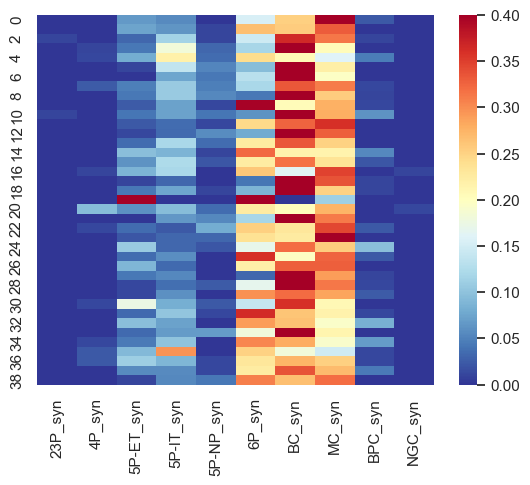

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sorted_synapse_table_percentage = synapse_table_percentage.sort_values(by='BC_syn')
sorted_synapse_table_percentage = synapse_table_percentage



#individual cells
heat_synapse_table = sorted_synapse_table_percentage[['23P_syn','4P_syn','5P-ET_syn','5P-IT_syn','5P-NP_syn','6P_syn','BC_syn','MC_syn','BPC_syn','NGC_syn']]
#heat_synapse_table_E = sorted_synapse_table_percentage[['23P_syn','4P_syn','5P-ET_syn','5P-IT_syn','5P-NP_syn','6P_syn']]
#heat_synapse_table_I = sorted_synapse_table_percentage[['BC_syn','MC_syn','BPC_syn','NGC_syn']]


#total percantages
#short_synapse = synapse_table_values[['all_23P_syn#','all_4P_syn#','all_5P-ET_syn#','all_5P-IT_syn#','all_5P-NP_syn#',
#                                      'all_6P_syn#','all_BC_syn#','all_MC_syn#','all_BPC_syn#','all_NGC_syn#']]
#total_percentages = pd.DataFrame(short_synapse.sum()) / pd.DataFrame(short_synapse.sum()).sum()

sns.set()

ax = sns.heatmap(heat_synapse_table, cmap='RdYlBu_r', vmin=0, vmax=0.40)


plt.savefig("Extended_Fig_8.pdf", format='pdf', dpi=1200)

plt.show()